In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from collections import Counter

In [ ]:
raw_df = pd.read_csv('heart.csv')

In [ ]:
raw_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Data Imbalance Check

In [ ]:
labels=["Healthy","Heart Disease"]

healthy_or_not = raw_df['HeartDisease'].value_counts().tolist()
values = [healthy_or_not[0], healthy_or_not[1]]

fig = px.pie(values=raw_df['HeartDisease'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Healthy vs Heart Disease")
fig.show()

In [ ]:
numerical_columns = list(raw_df.loc[:,['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']])
categorical_columns = list(raw_df.loc[:,['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']])

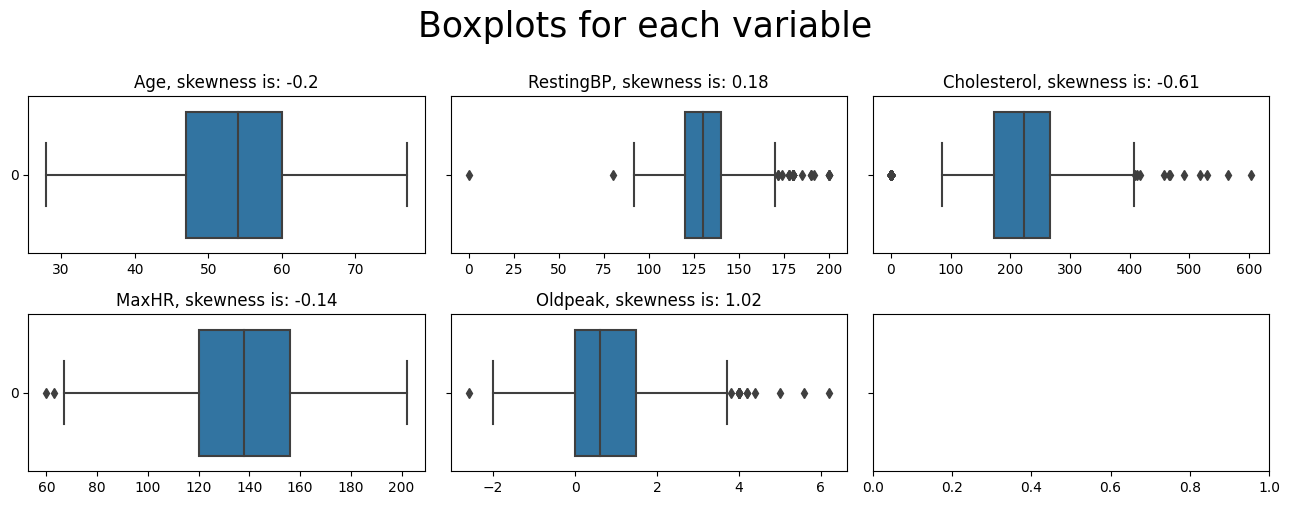

In [ ]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(13,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

boxplots_custom(dataset=raw_df, columns_list=numerical_columns, rows=2, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

In [ ]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []

    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers
        outlier_list.extend(outlier_list_column)

    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )

    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]

    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])

    return multiple_outliers

In [ ]:
# detecting outliers
Outliers_IQR = IQR_method(raw_df,1,numerical_columns)

# dropping outliers
df = raw_df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 16


In [ ]:
df = pd.get_dummies(df, drop_first=True)

In [ ]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Creating function for scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features

    return df

In [ ]:
col_names = numerical_columns
X_train = Standard_Scaler (X_train, col_names)
X_test = Standard_Scaler (X_test, col_names)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

In [ ]:
estimator = []
estimator.append(('Neural Network', MLPClassifier(max_iter = 10000) ))
estimator.append(('LogisticRegression', LogisticRegression(solver ='lbfgs', multi_class ='multinomial', max_iter = 200)))
estimator.append(('ExtraTreesClassifier', ExtraTreesClassifier() ))
estimator.append(('RandomForest', RandomForestClassifier() ))
#estimator.append(('KNN', KNeighborsClassifier() ))
estimator.append(('SVC', SVC(gamma ='auto', probability = True)))
estimator.append(('AdaBoostClassifier', AdaBoostClassifier() ))
estimator.append(('GradientBoostingClassifier', GradientBoostingClassifier() ))
estimator.append(('XGB', XGBClassifier() ))

Voting Classifier with hard voting

In [ ]:
VC_hard = VotingClassifier(estimators = estimator, voting ='hard')
VC_hard.fit(X_train, y_train)
y_pred = VC_hard.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       122
           1       0.91      0.91      0.91       150

    accuracy                           0.90       272
   macro avg       0.90      0.90      0.90       272
weighted avg       0.90      0.90      0.90       272



In [ ]:
cm = confusion_matrix(y_test, y_pred)

VC_hard_Recall = recall_score(y_test, y_pred)
VC_hard_Precision = precision_score(y_test, y_pred)
VC_hard_f1 = f1_score(y_test, y_pred)
VC_hard_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[109  13]
 [ 13 137]]


In [ ]:
from statistics import stdev
score = cross_val_score(VC_hard, X_train, y_train, cv=5, scoring='recall')
VC_hard_cv_score = score.mean()
VC_hard_cv_stdev = stdev(score)
print('Cross Validation Recall scores are: {}'.format(score))
print('Average Cross Validation Recall score: ', VC_hard_cv_score)
print('Cross Validation Recall standard deviation: ', VC_hard_cv_stdev)

Cross Validation Recall scores are: [0.92857143 0.82857143 0.81428571 0.92753623 0.89855072]
Average Cross Validation Recall score:  0.8795031055900621
Cross Validation Recall standard deviation:  0.05460090930020465


In [ ]:
ndf = [(VC_hard_Recall, VC_hard_Precision, VC_hard_f1, VC_hard_accuracy, VC_hard_cv_score, VC_hard_cv_stdev)]

VC_hard_score = pd.DataFrame(data = ndf, columns=
                        ['Recall','Precision','F1 Score', 'Accuracy', 'Avg CV Recall', 'Standard Deviation of CV Recall'])
VC_hard_score.insert(0, 'Voting Classifier', 'Hard Voting')
VC_hard_score

,Voting Classifier,Recall,Precision,F1 Score,Accuracy,Avg CV Recall,Standard Deviation of CV Recall
0,Hard Voting,0.913333,0.913333,0.913333,0.904412,0.879503,0.054601


Voting Classifier with soft voting

In [ ]:
VC_soft = VotingClassifier(estimators = estimator, voting ='soft')
VC_soft.fit(X_train, y_train)
y_pred = VC_soft.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       122
           1       0.91      0.91      0.91       150

    accuracy                           0.90       272
   macro avg       0.90      0.90      0.90       272
weighted avg       0.90      0.90      0.90       272



In [ ]:
cm = confusion_matrix(y_test, y_pred)

VC_soft_Recall = recall_score(y_test, y_pred)
VC_soft_Precision = precision_score(y_test, y_pred)
VC_soft_f1 = f1_score(y_test, y_pred)
VC_soft_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[109  13]
 [ 13 137]]


In [ ]:
score2 = cross_val_score(VC_soft, X_train, y_train, cv=5, scoring='recall')

In [ ]:
VC_soft_cv_score = score2.mean()
VC_soft_cv_stdev = stdev(score2)

print('Cross Validation Recall scores are: {}'.format(score2))
print('Average Cross Validation Recall score: ', VC_soft_cv_score)
print('Cross Validation Recall standard deviation: ', VC_soft_cv_stdev)

Cross Validation Recall scores are: [0.92857143 0.85714286 0.81428571 0.89855072 0.88405797]
Average Cross Validation Recall score:  0.8765217391304347
Cross Validation Recall standard deviation:  0.04330157335465363


In [ ]:
ndf2 = [(VC_soft_Recall, VC_soft_Precision, VC_soft_f1, VC_soft_accuracy, VC_soft_cv_score, VC_soft_cv_stdev)]

VC_soft_score = pd.DataFrame(data = ndf2, columns=
                        ['Recall','Precision','F1 Score', 'Accuracy', 'Avg CV Recall', 'Standard Deviation of CV Recall'])
VC_soft_score.insert(0, 'Voting Classifier', 'Soft Voting')
VC_soft_score

,Voting Classifier,Recall,Precision,F1 Score,Accuracy,Avg CV Recall,Standard Deviation of CV Recall
0,Soft Voting,0.913333,0.913333,0.913333,0.904412,0.876522,0.043302


In [ ]:
predictions = pd.concat([VC_hard_score, VC_soft_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Avg CV Recall'], ascending=False)

,Voting Classifier,Recall,Precision,F1 Score,Accuracy,Avg CV Recall,Standard Deviation of CV Recall
0,Hard Voting,0.913333,0.913333,0.913333,0.904412,0.879503,0.054601
1,Soft Voting,0.913333,0.913333,0.913333,0.904412,0.876522,0.043302


AUC-ROC Curve for Voting Classifier with soft voting
I present AUC-ROC Curve for Voting Classifier with soft voting, because predict_proba is not available when voting='hard'

In [ ]:
from sklearn.metrics import roc_auc_score
ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for Voting Classifier with soft voting: {ROCAUCscore:.4f}")

AUC-ROC Curve for Voting Classifier with soft voting: 0.9034


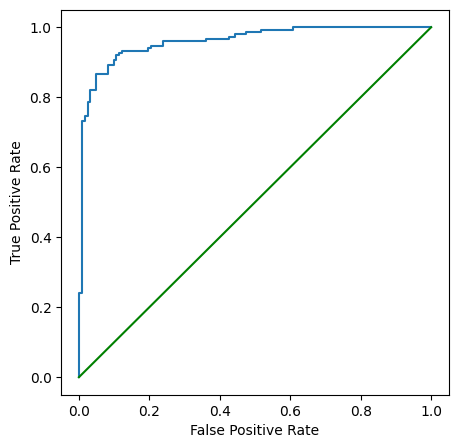

In [ ]:
y_proba = VC_soft.predict_proba(X_test)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
plot_auc_roc_curve(y_test, y_proba[:, 1])
# Plots the ROC curve using the sklearn methods - Bad plot
#plot_sklearn_roc_curve(y_test, y_pred)

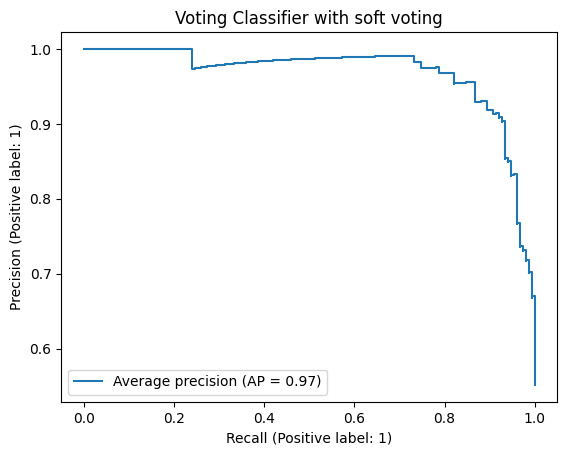

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    VC_soft, X_test, y_test, name="Average precision")
_ = display.ax_.set_title("Voting Classifier with soft voting")